# Prior Distributions

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager
import torch
import pickle
import prior.CustomDistribution as custom
import config


from polynomials import Polynomial
from block_utils import transfrom_and_find_max_reached_depth
from block_utils import map_resistivities_to_depth


from util import svg

from matplotlib.collections import LineCollection
from matplotlib.colors import BoundaryNorm, ListedColormap

from sbi import utils as utils
from sbi.utils import user_input_checks as uic

from svgutils.compose import *

_ = torch.manual_seed(0)

2024-07-03 18:46:29.195706: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-03 18:46:29.956861: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-03 18:46:29.956903: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-03 18:46:29.956936: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-03 18:46:30.446494: I tensorflow/core/platform/cpu_feature_g

In [2]:
max_depth= 23.5
step_size= 0.5
num_points= int(max_depth/step_size) +1 
max_resistivity = 1_000
min_resistivity = 1
num_measurements = 23
num_dim = 48

depths = np.linspace(0, max_depth, num=num_dim)

In [3]:
def plot_prior_dist(prior_samples, filename, n_samples, step=False, yaxis_visible=True, depths=depths): 
    with mpl.rc_context(fname="plots/pltstyle_prior.rc"):
        fig = plt.figure(figsize=(8,10))
        ax1 = fig.add_axes([0.1, 0.1, 0.75, 0.85])

        # Stack the polynomials to get the minimum and maximum values at each point
        prior_stack = np.stack(prior_samples)
        
        # Compute the minimum and maximum values at each x-coordinate
        step_min = np.nanmin(prior_stack, axis=0)
        step_max = np.nanmax(prior_stack, axis=0)

        # Shaded region to indicate the range of polynomial values
        plt.fill_betweenx(depths, step_min, step_max, color='forestgreen', alpha=0.4, label='Covered Range')

        # Plot each polynomial
        for sample in prior_samples[:n_samples]:

            if step:
                plt.plot(sample, depths, color='black', alpha = 0.5, linewidth=2, drawstyle='steps-pre')
            else: 
                plt.plot(sample, depths, color='black', alpha=0.5, linewidth=2)
        # Move the bottom spine (x-axis) downwards
        ax1.spines['bottom'].set_position(('outward', 10))  # Move down by 5 points
        
        # Move the left spine (y-axis) to the left
        ax1.spines['left'].set_position(('outward', 10))  # Move left by 5 points
        
        # Hide the top and right spines
        ax1.spines['top'].set_color('none')
        ax1.spines['right'].set_color('none')
        
        # Optionally, adjust the ticks
        ax1.xaxis.set_ticks_position('bottom')
        ax1.yaxis.set_ticks_position('left')

        ax1.set_ylabel("Depth [m]", labelpad=15)
        ax1.set_xlabel("Resistivity  [$\Omega m$]", labelpad=15)
        
        ax1.get_yaxis().set_visible(yaxis_visible)
        ax1.spines['left'].set_visible(yaxis_visible)

        # Invert y axis to represent depth
        plt.gca().invert_yaxis()

        plt.savefig('plots/prior/{}'.format(filename))
        plt.show()




## Step Prior

In [4]:
# Prior Setup
prior_high_res= max_resistivity
prior_low_res=1
custom_prior = custom.CustomDistribution(low=prior_low_res, high=prior_high_res, dimension=num_dim)
prior_step,* _ = uic.process_prior(custom_prior,
                                custom_prior_wrapper_kwargs=dict(
                                    lower_bound = torch.tensor([custom_prior.low]* custom_prior.dimension),
                                    upper_bound = torch.tensor([custom_prior.high] * custom_prior.dimension)
                                    )
                                )


/opt/bwhpc/common/jupyter/tensorflow/2023-10-10/lib/python3.9/site-packages/torch/distributions/distribution.py:53: UserWarning: <class 'prior.CustomDistribution.CustomDistribution'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


Duplicate key in file 'plots/pltstyle_prior.rc', line 35 ('axes.labelsize       : large  # fontsize of the x any y labels')


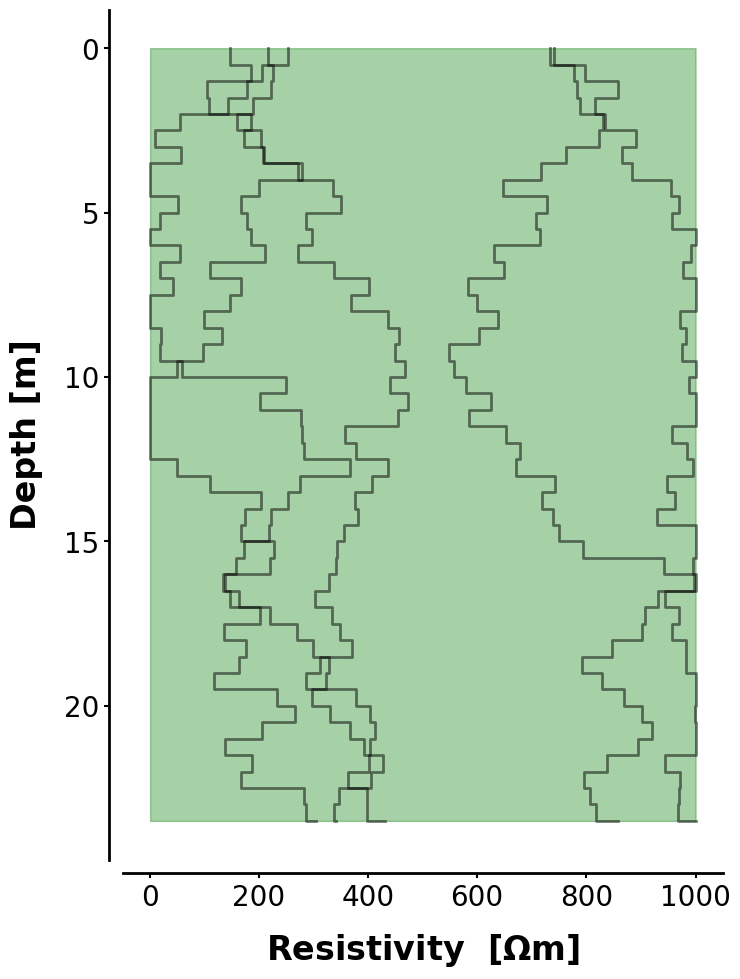

In [5]:
prior_samples_step = prior_step.sample((10000,))

plot_prior_dist(prior_samples_step, filename='step_samples_l.svg', n_samples=5, step=True)

## Independent Step Prior

In [6]:
# Prior Setup
prior_min = torch.as_tensor([min_resistivity] * num_dim)
prior_max = torch.as_tensor([max_resistivity] * num_dim)
prior_ind_step = utils.BoxUniform(low=prior_min * torch.ones(num_dim), high=prior_max * torch.ones(num_dim))  

prior_samples_ind_step = prior_ind_step.sample((10000,))

Duplicate key in file 'plots/pltstyle_prior.rc', line 35 ('axes.labelsize       : large  # fontsize of the x any y labels')


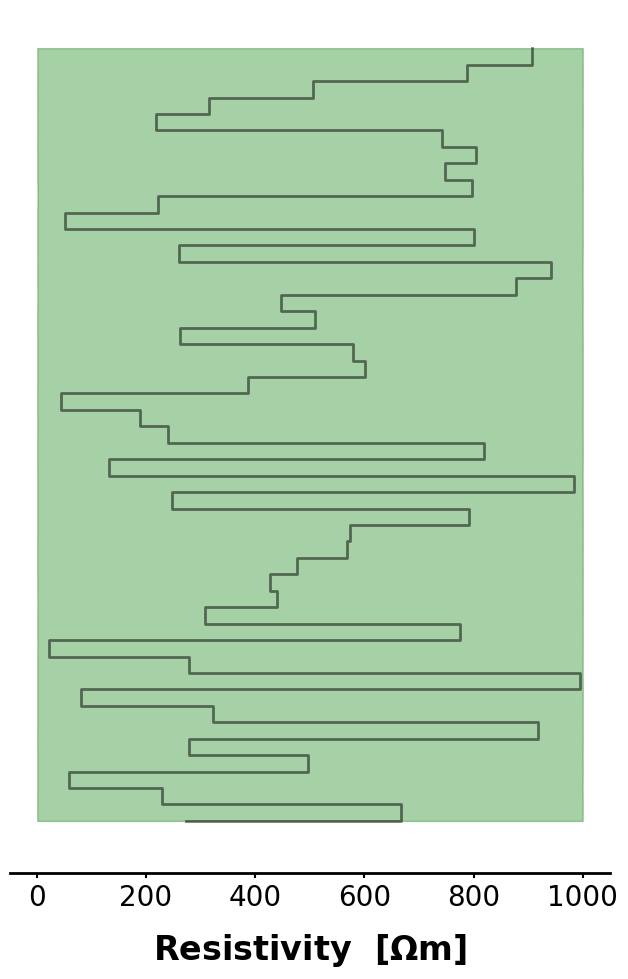

In [7]:
plot_prior_dist(prior_samples_ind_step, filename='ind_step_samples_l.svg', step=True, n_samples=1, yaxis_visible=False)

## Polynomial Prior

In [8]:
polynomial = Polynomial(max_depth=max_depth, num_dim=num_dim, max_res=max_resistivity, num_measurements=num_measurements)

# Prior Setup 
num_dim_prior = 5
prior_min = torch.as_tensor([-1] * num_dim_prior)
prior_max = torch.as_tensor([ 1] * num_dim_prior)
prior_poly = utils.BoxUniform(low=prior_min * torch.ones(num_dim_prior), high=prior_max * torch.ones(num_dim_prior)) 


In [9]:
remaining_simulations=10_000
prior_samples_poly = torch.tensor(())
samples_poly_to_res = torch.tensor(())
while remaining_simulations > 0: 
    samples = prior_poly.sample((remaining_simulations*8,))
    samples_to_res = torch.tensor(np.array([polynomial.coefficients_to_resistivity(sample) for sample in samples]))
    valid_simulations = torch.all(~torch.isnan(samples_to_res), dim=1)
    if any(valid_simulations):
        # Concatenate valid simulations directly
        prior_samples_poly = torch.cat((prior_samples_poly, samples[valid_simulations]), dim=0)
        samples_poly_to_res = torch.cat((samples_poly_to_res, samples_to_res[valid_simulations]), dim=0)
        remaining_simulations -= torch.sum(valid_simulations).item()

Duplicate key in file 'plots/pltstyle_prior.rc', line 35 ('axes.labelsize       : large  # fontsize of the x any y labels')


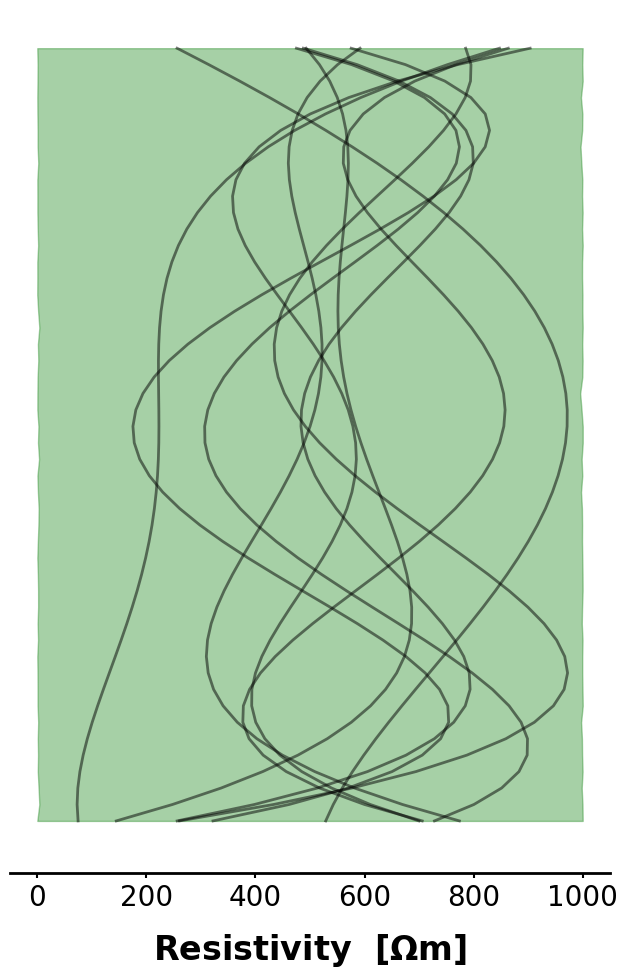

In [10]:
plot_prior_dist(samples_poly_to_res, filename='poly_samples_l.svg', step=False, n_samples=10, yaxis_visible=False)

## Block Prior

In [11]:
n_blocks = 4 
res_prior_min = torch.as_tensor([min_resistivity] * n_blocks)
res_prior_max = torch.as_tensor([max_resistivity] * n_blocks)

n_thickness = 3
min_thickness = 0.1
max_thickness = 20.
thickness_prior_min = torch.as_tensor([min_thickness] * n_thickness)
thickness_prior_max = torch.as_tensor([max_thickness] * n_thickness)

prior_min = torch.cat([res_prior_min, thickness_prior_min])
prior_max = torch.cat([res_prior_max, thickness_prior_max])

prior_block = utils.BoxUniform(low=prior_min, high=prior_max)

In [12]:
prior_samples_block = prior_block.sample((10_000,))
inv_res_thick_depth, max_depth = transfrom_and_find_max_reached_depth(prior_samples_block)
prior_samples_to_depth = map_resistivities_to_depth(inv_res_thick_depth, max_depth)

Duplicate key in file 'plots/pltstyle_prior.rc', line 35 ('axes.labelsize       : large  # fontsize of the x any y labels')


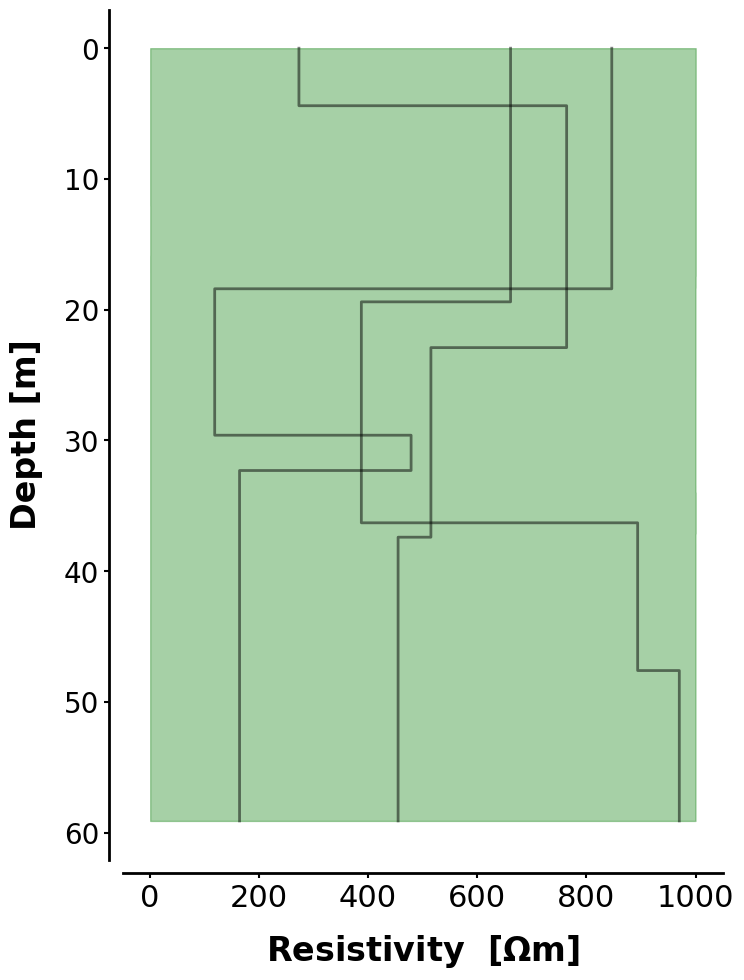

In [21]:
#depths_block = np.linspace(0, max_depth, num=int(max_depth/0.1), endpoint=False)
plot_prior_dist(prior_samples_to_depth, filename='block_samples_l.svg', step=True, n_samples=3, yaxis_visible=True, depths=depths_block)

## Merge plots into one figure

In [14]:
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '14pt', 'weight': '800'}
kwargs_text_light = {'size': '10pt',  'weight': '600'}

f = Figure("70cm", "30cm",    

    Panel(
        SVG("plots/prior/block_samples_l.svg").scale(svg_scale),
        Text("d", 0, 70, **kwargs_text)
    ).move(1870, 20),
           
    Panel(
        SVG("plots/prior/ind_step_samples_l.svg").scale(svg_scale),
        Text("c", 0, 70, **kwargs_text)
    ).move(1300, 20),               
             
    Panel(
        SVG("plots/prior/poly_samples_l.svg").scale(svg_scale),
        Text("b", 0, 70,**kwargs_text )
    ).move(720, 20),

   Panel(
        SVG("plots/prior/step_samples_l.svg").scale(svg_scale),
        Text("a", 0 , 70, **kwargs_text)
    ).move(50, 20),
         
)

f.save("plots/figures/fig_prior/prior_samples_l.svg")
svg("plots/figures/fig_prior/prior_samples_l.svg")

#### Plot the priors in a 2x2 grid

In [15]:
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '14pt', 'weight': '800'}
kwargs_text_light = {'size': '10pt',  'weight': '600'}

f = Figure("40cm", "40cm",    
           
    Panel(
        SVG("plots/prior/ind_step_samples_yaxis.svg").scale(svg_scale),
        Text("c", 0, 70, **kwargs_text)
        #   x, y
    ).move(50, 750),
        
    
    Panel(
        SVG("plots/prior/block_samples.svg").scale(svg_scale),
        Text("d", 0, 70, **kwargs_text)
    ).move(700, 750),
           
             
    Panel(
        SVG("plots/prior/step_samples.svg").scale(svg_scale),
        Text("a", 0 , 70, **kwargs_text)
    ).move(50, 20),

    Panel(
        SVG("plots/prior/poly_samples.svg").scale(svg_scale),
        Text("b", 0, 70,**kwargs_text )
    ).move(770, 20),
)

f.save("plots/figures/fig_prior/prior_samples.svg")
svg("plots/figures/fig_prior/prior_samples.svg")